In [1]:
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import os
import mlflow

In [3]:
MLFLOW_IP = os.environ['MLFLOW_IP']
MLFLOW_PASSWORD = os.environ['MLFLOW_PASSWORD']
MLFLOW_USER = os.environ['MLFLOW_USER']
MLFLOW_PORT = os.environ['MLFLOW_PORT']

# Obtaining data

In [4]:
now_time = datetime.now()
start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
print(start_time, now_time)

data = pdr.get_data_yahoo('AAPL', start_time, now_time)
data

2018-01-18 00:00:00 2023-01-18 08:37:07.024494
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-18 00:00:00-05:00,44.842499,45.025002,44.562500,44.814999,42.614578,124773600
2018-01-19 00:00:00-05:00,44.652500,44.895000,44.352501,44.615002,42.424389,129700400
2018-01-22 00:00:00-05:00,44.325001,44.445000,44.150002,44.250000,42.077309,108434400
2018-01-23 00:00:00-05:00,44.325001,44.860001,44.205002,44.259998,42.086811,130756400
2018-01-24 00:00:00-05:00,44.312500,44.325001,43.299999,43.555000,41.416447,204420400
...,...,...,...,...,...,...
2023-01-10 00:00:00-05:00,130.259995,131.259995,128.119995,130.729996,130.729996,63896200
2023-01-11 00:00:00-05:00,131.250000,133.509995,130.460007,133.490005,133.490005,69458900
2023-01-12 00:00:00-05:00,133.880005,134.259995,131.440002,133.410004,133.410004,71379600


In [5]:
# Check for missing values
data.isnull().sum()/len(data)

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

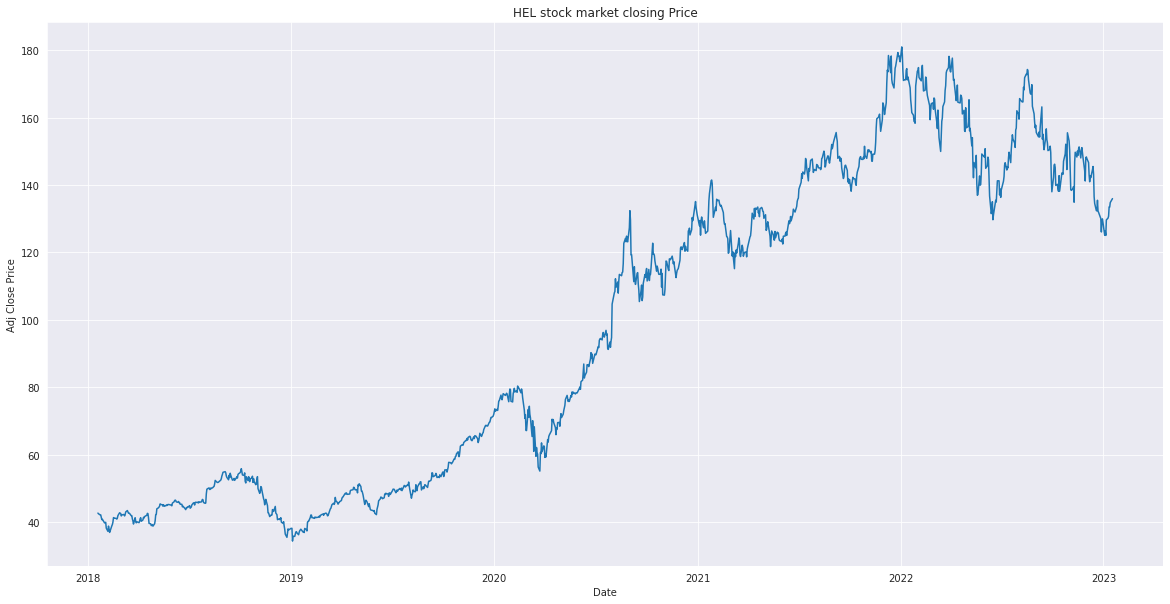

In [6]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('HEL stock market closing Price')
plt.plot(data['Adj Close'])

# Checking the stationarity

In [7]:
def test_adf(timeseries):
    
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(moving_average, color='red', label='Rolling Mean')
    plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of dickey fuller test')
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical value {key}'] = value
    print(output)
    

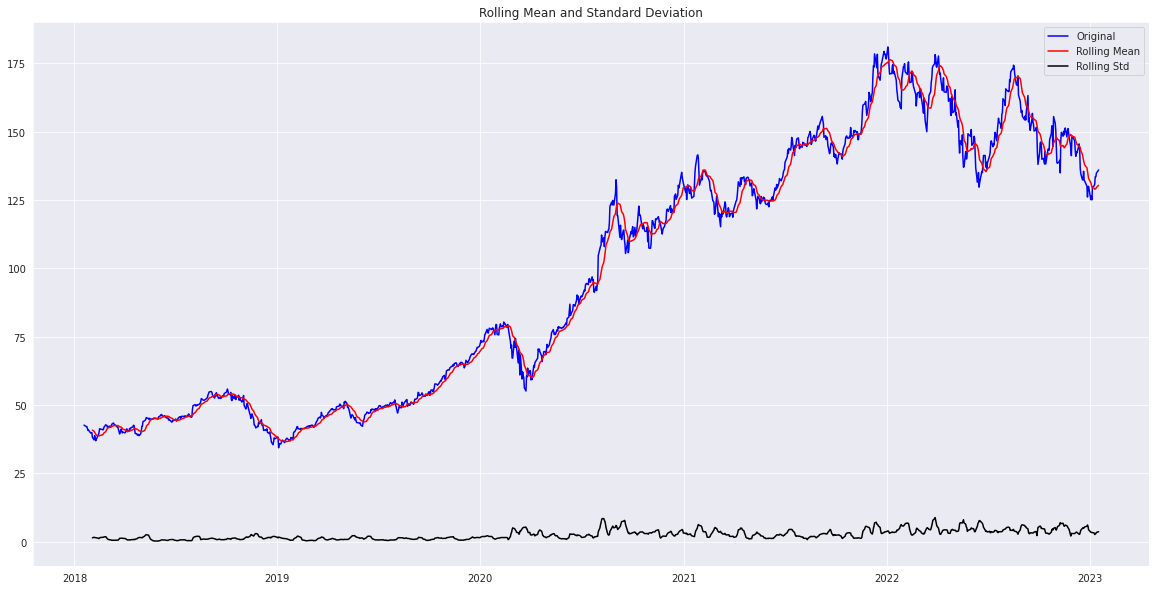

Results of dickey fuller test
Test Statistics                  -1.097703
p-value                           0.715987
No. of lags used                 11.000000
Number of observations used    1246.000000
Critical value 1%                -3.435609
Critical value 5%                -2.863862
Critical value 10%               -2.568006
dtype: float64


In [8]:
test_adf(data['Adj Close'])

In [9]:
data_adj_close = data['Adj Close'].tolist()

<Figure size 432x288 with 0 Axes>

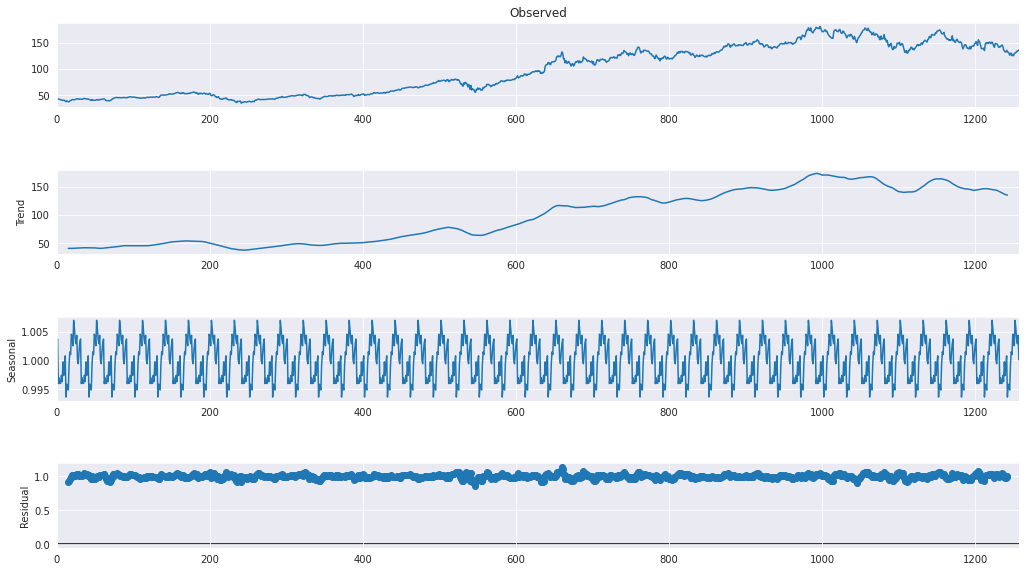

In [10]:
result = seasonal_decompose(data_adj_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

# Converting non-stationary to stationary data

In [11]:
data_adj_close_log = np.log(data_adj_close)
df_data_adj_close_log = pd.DataFrame({'Adj_Close': data_adj_close_log})
moving_average = df_data_adj_close_log.rolling(12).mean()
std_dev = df_data_adj_close_log.rolling(12).std()

No handles with labels found to put in legend.


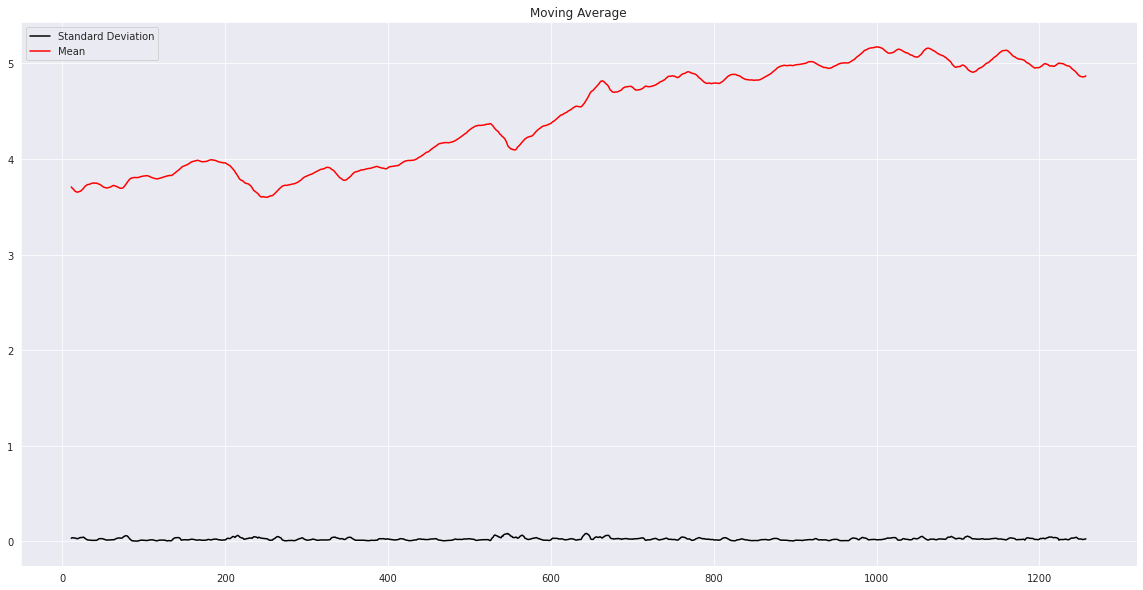

In [12]:
rcParams['figure.figsize'] = 20, 10
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_average, color='red', label='Mean')
plt.legend()
plt.show()

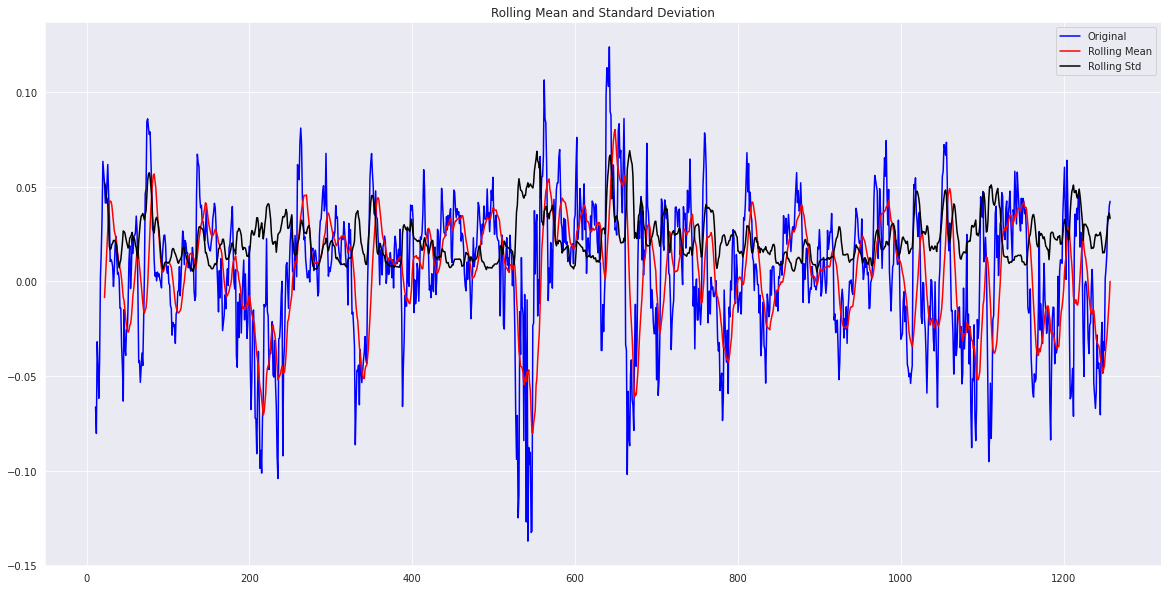

Results of dickey fuller test
Test Statistics               -6.986609e+00
p-value                        7.938896e-10
No. of lags used               1.100000e+01
Number of observations used    1.235000e+03
Critical value 1%             -3.435656e+00
Critical value 5%             -2.863883e+00
Critical value 10%            -2.568018e+00
dtype: float64


In [13]:
data_log_minus_mean = df_data_adj_close_log - moving_average
data_log_minus_mean.dropna(inplace=True)
test_adf(data_log_minus_mean)

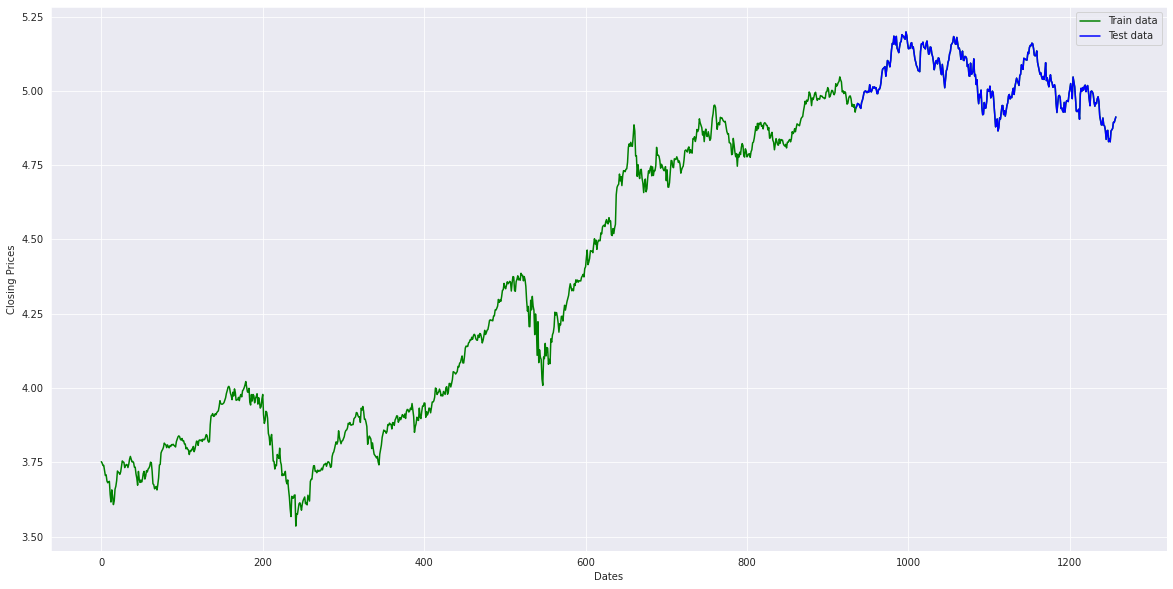

In [14]:
train_data, test_data = (df_data_adj_close_log[:int(len(data_adj_close_log)*0.75)], 
                         df_data_adj_close_log[int(len(data_log_minus_mean)*0.75):])
plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_adj_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Auto ARIMA

In [15]:
mlflow.set_tracking_uri('http://{}:{}'.format(MLFLOW_IP, MLFLOW_PORT))

# exp_id = mlflow.create_experiment(
#     name='ARIMA',
#     artifact_location="sftp://{}:{}@{}:/home/godder/mlflow_storage/artifacts".format(MLFLOW_USER, MLFLOW_PASSWORD, MLFLOW_IP),
#     tags={'ticker':'AAPL'}
# )

exp_id = mlflow.get_experiment_by_name('ARIMA').experiment_id

mlflow.set_experiment(experiment_id=exp_id)
print('done')

mlflow.start_run(experiment_id=exp_id, run_name='ARIMA training')

mlflow.set_tag('ticker', 'AAPL')

mlflow.log_param('start_p', 0)
mlflow.log_param('start_q', 0)
mlflow.log_param('maxiter', 1000)
mlflow.log_param('test', 'adf')
mlflow.log_param('max_p', 40)
mlflow.log_param('max_q', 40)
mlflow.log_param('m', 1)
mlflow.log_param('d', None)
mlflow.log_param('seasonal', False)
mlflow.log_param('start_P', 0)
mlflow.log_param('n_fits', 100)
mlflow.log_param('D', 0)

done


0

In [17]:
import pmdarima

In [18]:
m = pmdarima.auto_arima(train_data.values)

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, maxiter=1000,
                                test='adf', max_p=40, max_q=40, m=1,
                                d=None, seasonal=False, start_P=0, n_fits=100,
                                D=0, trace=True, error_action='ignore',
                                suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4592.856, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4610.785, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4609.817, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4591.376, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4609.045, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4609.081, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4606.794, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4608.161, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.662 seconds


# ARIMA

In [20]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted = model.fit()

In [21]:
mlflow.log_metric('train/aic', fitted.aic)

In [22]:
fitted.forecast(test_data.shape[0], alpha=0.05)

943     4.958083
944     4.958480
945     4.958424
946     4.958432
947     4.958431
          ...   
1261    4.958431
1262    4.958431
1263    4.958431
1264    4.958431
1265    4.958431
Name: predicted_mean, Length: 323, dtype: float64

In [23]:
fitted.conf_int()

,0,1
ar.L1,-0.179989,-0.101312
sigma2,0.000415,0.000460


/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


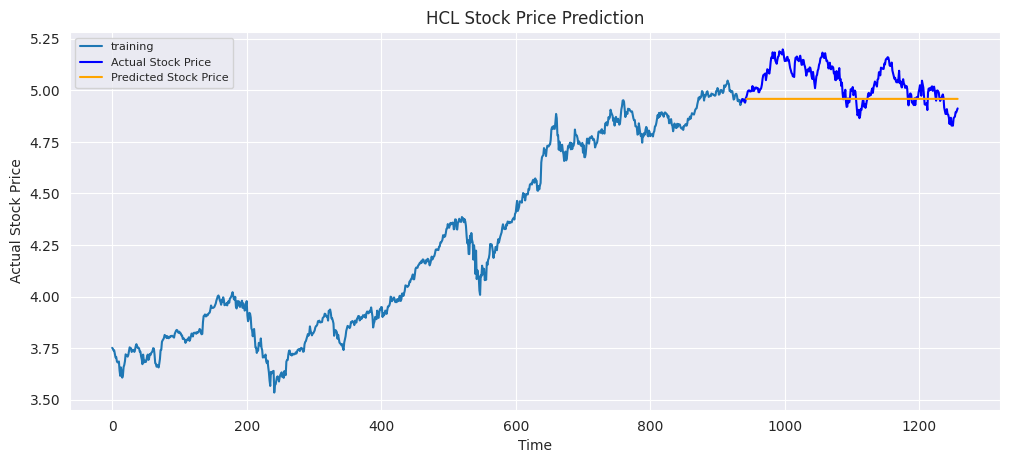

In [24]:
fc = fitted.forecast(test_data.shape[0], alpha=0.05)
conf = fitted.conf_int()
fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[0].to_list(), index=test_data.index)
# upper_series = pd.Series(conf[1].to_list(), index=test_data.index)

fig = plt.figure(figsize=(12,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(train_data, label='training')
ax.plot(test_data, color='blue', label='Actual Stock Price')
ax.plot(fc_series, color='orange', label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
ax.set_title('HCL Stock Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Actual Stock Price')
ax.legend(loc='upper left', fontsize=8)
mlflow.log_figure(fig, 'pred_plot.png')
plt.show()

In [25]:
signature = mlflow.models.signature.infer_signature(pd.DataFrame([{"n_periods": 10, "return_conf_int": True, "alpha": 0.1}]))

/home/godder/.local/lib/python3.8/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [26]:
mlflow.pmdarima.log_model(m, 'ARIMA', registered_model_name='ARIMA',
                         signature=signature,
                         input_example=pd.DataFrame([{"n_periods": 10, "return_conf_int": True, "alpha": 0.1}]))

Registered model 'ARIMA' already exists. Creating a new version of this model...
2023/01/18 08:37:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ARIMA, version 3
Created version '3' of model 'ARIMA'.


In [27]:
mlflow.end_run()

# Forecasting and fetching

In [28]:
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/ARIMA/2"
)

In [29]:
model.predict(pd.DataFrame([{"n_periods": 10, "return_conf_int": True, "alpha": 0.1}]))

,yhat,yhat_lower,yhat_upper
0,4.959467,4.925148,4.993787
1,4.961142,4.915984,5.006300
2,4.962367,4.908113,5.016620
3,4.963657,4.901678,5.025635
4,4.964937,4.896088,5.033786
5,4.966219,4.891127,5.041311
6,4.967500,4.886645,5.048355
7,4.968782,4.882548,5.055016
8,4.970064,4.878768,5.061360
9,4.971345,4.875253,5.067437


In [31]:
tracking_uri = mlflow.get_tracking_uri()
registry_uri = mlflow.get_registry_uri()

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)
client.transition_model_version_stage(
    name="ARIMA",
    version=3,
    stage="Staging"
)
client.transition_model_version_stage(
    name="ARIMA",
    version=2,
    stage="Archived"
)
print('done')

done
